In [ ]:
import pandas as pd
import numpy as np
from hpelm import ELM
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import itertools

df = pd.read_excel('final_dataset.xlsx')

drop_columns = ["Seli", "mccinfo", "Şehir", "İlçe"]
df = df.drop(columns=drop_columns)

cols_to_convert = [
    "bıst100_Şimdi", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Şimdi", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Şimdi", "USD_Açılış", "USD_Yüksek", "USD_Düşük"
]

def turkish_str_to_float(x):
    if isinstance(x, str):
        x = x.replace('.', '').replace(',', '.')
    try:
        return float(x)
    except:
        return None

for col in cols_to_convert:
    df[col] = df[col].apply(turkish_str_to_float)

df = df.drop(columns=["Tarih"])

target_col = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target_col]).values
y = df[target_col].values

In [ ]:
# Hiperparametre
param_grid = {
    'n_hidden': [25,50, 100, 200,300],
    'activation': ['sigm', 'tanh',]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

best_r2 = -np.inf
best_params = None
results = []

# Grid Search
for n_hidden, activation in itertools.product(param_grid['n_hidden'], param_grid['activation']):
    mae_list, mape_list, r2_list = [], [], []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Özellikleri ölçeklendirme
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # ELM modeli
        elm = ELM(X_train.shape[1], 1)
        elm.add_neurons(n_hidden, activation)
        
        # Regresyon modu
        elm.train(X_train, y_train.reshape(-1, 1), 'r')
        
        # Tahminler
        y_pred = elm.predict(X_test).ravel()
        
        # Metrikleri hesaplıyoruz.
        mae_list.append(mean_absolute_error(y_test, y_pred))
        mape_list.append(mean_absolute_percentage_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))
    
    # Ortalama metrikler
    avg_mae = np.mean(mae_list)
    avg_mape = np.mean(mape_list)
    avg_r2 = np.mean(r2_list)
    
    results.append({
        'n_hidden': n_hidden,
        'activation': activation,
        'MAE': avg_mae,
        'MAPE': avg_mape,
        'R2': avg_r2
    })
    
    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_params = {'n_hidden': n_hidden, 'activation': activation}

print("Grid Search Sonuçları:")
for res in results:
    print(res)

print("\nEn iyi parametreler:")
print(best_params)
print("MAE:", avg_mae)
print("MAPE:", avg_mape)
print("R2:", best_r2)

Grid Search Sonuçları:
{'n_hidden': 25, 'activation': 'sigm', 'MAE': 0.5260782067806339, 'MAPE': 0.13395989633086883, 'R2': 0.16505755105668737}
{'n_hidden': 25, 'activation': 'tanh', 'MAE': 0.6344679724786118, 'MAPE': 0.15594342419575427, 'R2': -0.24824383522145393}
{'n_hidden': 50, 'activation': 'sigm', 'MAE': 0.5284006542707793, 'MAPE': 0.13382711034144235, 'R2': 0.1389798129226965}
{'n_hidden': 50, 'activation': 'tanh', 'MAE': 0.5528092307804956, 'MAPE': 0.13841654703645134, 'R2': -0.05764936070214314}
{'n_hidden': 100, 'activation': 'sigm', 'MAE': 0.5483402895647174, 'MAPE': 0.13953692586002525, 'R2': -0.5027744544122082}
{'n_hidden': 100, 'activation': 'tanh', 'MAE': 0.5173394341154915, 'MAPE': 0.13025117144898118, 'R2': 0.09163199429615378}
{'n_hidden': 200, 'activation': 'sigm', 'MAE': 0.6860559533021162, 'MAPE': 0.17909698258479292, 'R2': -10.394197175119668}
{'n_hidden': 200, 'activation': 'tanh', 'MAE': 0.5667218937753528, 'MAPE': 0.14271445875037717, 'R2': -0.77036194294737

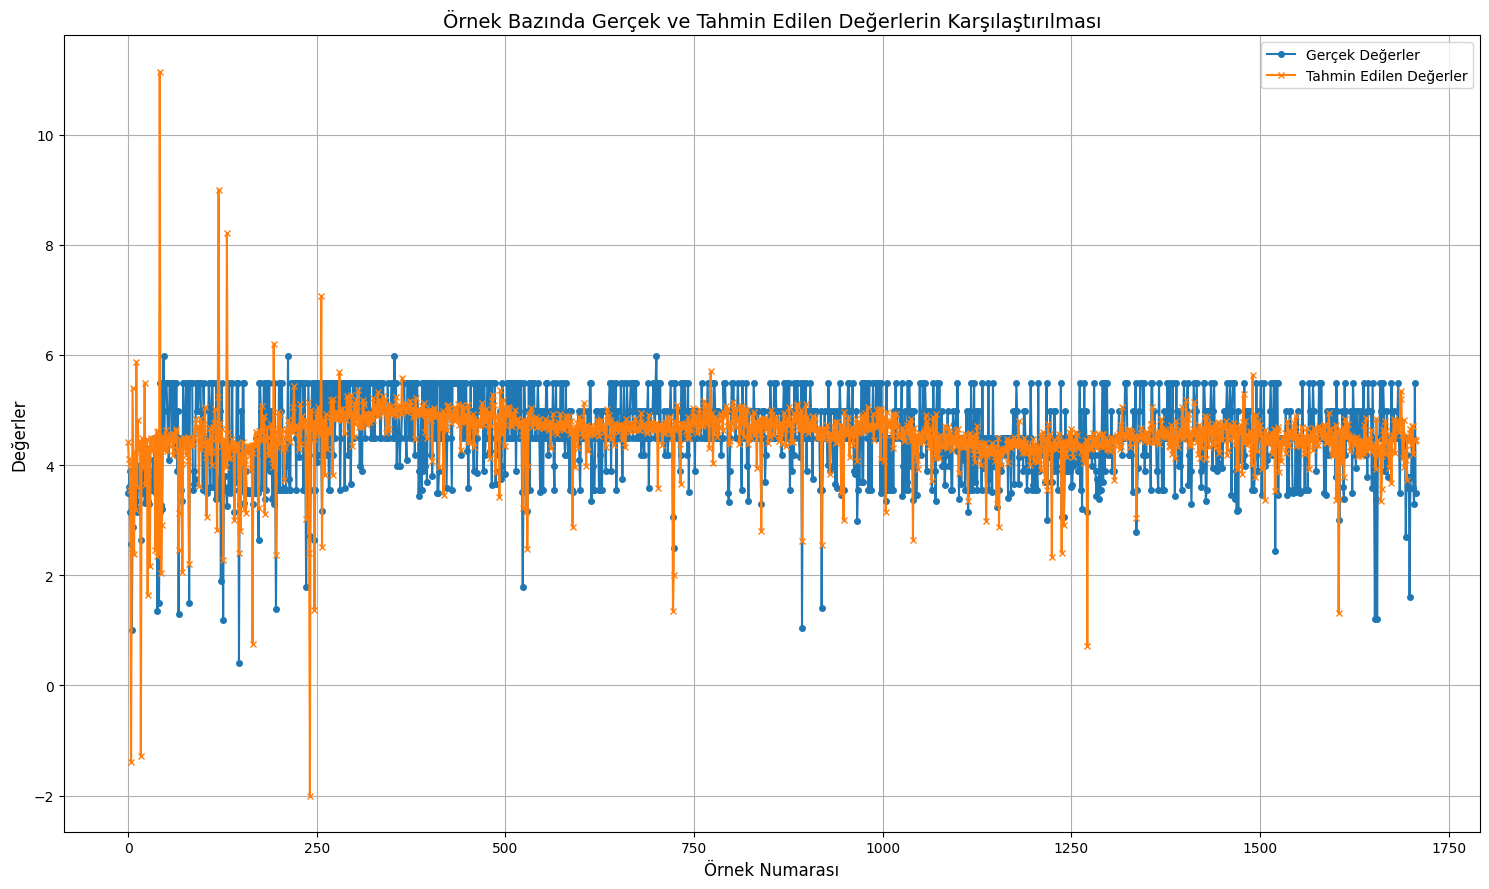

In [22]:
# --- Tahmin ve Gerçek Değerlerin Grafiksel Gösterimi (Örnek Bazında) ---
plt.figure(figsize=(15,9), dpi=100)
# Örnek numarası x ekseninde
sample_index = range(len(all_y_true))

# Gerçek değerler ve tahmin edilen değerleri çiziyoruz.
plt.plot(sample_index, all_y_true, label="Gerçek Değerler", marker='o', linestyle='-', markersize=4)
plt.plot(sample_index, all_y_pred, label="Tahmin Edilen Değerler", marker='x', linestyle='-', markersize=4)

plt.xlabel("Örnek Numarası", fontsize=12)
plt.ylabel("Değerler", fontsize=12)
plt.title("Örnek Bazında Gerçek ve Tahmin Edilen Değerlerin Karşılaştırılması", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
